## Description
This is to demonstrate the use of neural network for predicting of house prices based on their specific characteristcs. <br>
The data is a set of housing prices in Boston from the mid 70s.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the demand for clean air', J. Environ. Economics & Management, <br>
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics ...', Wiley, 1980.   N.B. Various transformations are used in the table on <br>
pages 244-261 of the latter.

### 1. Setup

In [2]:
# import local libs - this must precede any other imports of keras and its backends 
from classifiers import System
from classifiers.utils import random_classifier
from classifiers.text import Vectorizer, Splitter, System
from classifiers.utils import normalize, print_performance_metrics, smooth_curve

# import standard libs and setup the keras backend
import os

# import third-party libs
import keras
from keras.datasets import boston_housing
from keras import layers
from keras import models
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np

# plots will be printed in the notebook
%matplotlib inline

System.print_info()

System Information:
-------------------
Keras Backend: tensorflow
Tensorflow log level: 1
CPUs Available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
-------------------


### 2. Data preparation

In [3]:
print('Preparing data...', end='')

# load data - 506 samples, from which 404 are training samples, 102 are testing samples;
# the predicted values represent thousands of USD
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

# since the training params come as distict values, they must be 
# normalized before passing to the neural network
x_train_norm, x_test_norm = normalize(x_train, x_test)

print('done.\n')

print('Sample description:')
print('-------------------')
print('CRIM:', x_train[0][0], '= per capita crime rate by town')
print('ZN:', x_train[0][1], '= proportion of residential land zoned for lots over 25,000 sq.ft.')
print('INDUS:', x_train[0][2], '= proportion of non-retail business acres per town')
print('CHAS:', x_train[0][3], '= Charles River dummy variable (1 if tract bounds river; 0 otherwise)')
print('NOX:', x_train[0][4], '= nitric oxides concentration (parts per 10 million)')
print('RM:', x_train[0][5], '= average number of rooms per dwelling')
print('AGE:', x_train[0][6], '= proportion of owner-occupied units built prior to 1940')
print('DIS:', x_train[0][7], '= weighted distances to five Boston employment centres')
print('RAD:', x_train[0][8], '= index of accessibility to radial highways')
print('TAX:', x_train[0][9], '= full-value property-tax rate per 10.000 USD')
print('PTRATIO:', x_train[0][10], '= pupil-teacher ratio by town')
print('LSTAT:', x_train[0][11], '= % lower status of the population')
print('MEDV:', x_train[0][12], '= % Median value of owner-occupied homes in $1000')

Preparing data...done.

Sample description:
-------------------
CRIM: 1.23247 = per capita crime rate by town
ZN: 0.0 = proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS: 8.14 = proportion of non-retail business acres per town
CHAS: 0.0 = Charles River dummy variable (1 if tract bounds river; 0 otherwise)
NOX: 0.538 = nitric oxides concentration (parts per 10 million)
RM: 6.142 = average number of rooms per dwelling
AGE: 91.7 = proportion of owner-occupied units built prior to 1940
DIS: 3.9769 = weighted distances to five Boston employment centres
RAD: 4.0 = index of accessibility to radial highways
TAX: 307.0 = full-value property-tax rate per 10.000 USD
PTRATIO: 21.0 = pupil-teacher ratio by town
LSTAT: 396.9 = % lower status of the population
MEDV: 18.72 = % Median value of owner-occupied homes in $1000


### 3. Model compilation, training and evaluation

In [4]:
def build_model(input_dim):

    model = models.Sequential()
    
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1)) # scalar regression, hence no activation function

    model.compile(
        optimizer='rmsprop',
        loss='mse',
        metrics=['mae']
    )

    return model

def plot_training_performance(history):

    # evaluate training parameters
    training_loss = history.history['loss']
    training_accuracy = history.history['accuracy']
    training_mae = history.history['mae']
    epochs=range(1, len(training_loss) + 1)

    # plot the paramters
    plt.plot(epochs, training_loss, 'g', label='Training loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.show()
    
    # clear prev plot
    plt.clf()

    plt.plot(epochs, training_accuracy, 'g', label='Training accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()
    plt.show()

    # clear prev plot
    plt.clf()
    
    plt.plot(epochs, training_mae, 'g', label='Training mean absolute error')
    plt.title('Training mean absolute error (MAE)')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.xticks(epochs)
    plt.legend()
    plt.show()

# hyperparameters
k = 4
n_epochs=100
n_valid_samples = len(x_train_norm) // k
input_dim = x_train_norm.shape[1]

mean_mae_per_model=[]
all_mae_vals=[]
mae_vals_per_model=[]

for fold in range(k):
    
    print(f'Processing fold # {fold + 1} of {k} ...')
    
    # generate split indexes
    start_idx = fold * n_valid_samples
    end_idx = (fold + 1) * n_valid_samples

    # prep validation data
    x_valid_norm = x_train_norm[start_idx: end_idx]
    y_valid = y_train[start_idx: end_idx]

    # prepare values for training
    x_partial_train = np.concatenate([
            x_train_norm[:start_idx],
            x_train_norm[end_idx:]
        ], axis=0
    )

    # prepare predicted values for training
    y_partial_train = np.concatenate([
            y_train[:start_idx],
            y_train[end_idx:]
        ], axis=0
    )

    # create a new model for every fold
    model = build_model(input_dim)

    # train the model
    history = model.fit(
        x_partial_train,
        y_partial_train,
        epochs=n_epochs,
        batch_size=1,
        verbose=0,
        validation_data=(
            x_valid_norm,
            y_valid
        )
    )

    # evaluate the trained model
    val_mse, val_mae = model.evaluate(x_test_norm, y_test)

    # plot model performance
    print_performance_metrics({
        'Testing loss (MSE)': val_mse,
        'Testing MAE': val_mae
    })
    # plot_training_performance(history)

    # collect the MAE
    vals_mae = history.history['val_mae'] # MAEs per n epochs
    all_mae_vals.extend(vals_mae)
    mae_vals_per_model.append(vals_mae)
    mean_mae_per_model.append(float(np.mean(vals_mae))) 


# once the hyperparameters are tuned up, the model will be 
# retrained on training and validation data no.concatenate(traiing, validation)
# and evaluated on testing data. the concatenation is beneficial in case of
# a small data set. Normally, this is not necessary with large data sets.


Processing fold # 1 of 4 ...


I0000 00:00:1730110689.182093  123234 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2172 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1730110690.093391  123305 service.cc:148] XLA service 0x79e1cc004fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730110690.093417  123305 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
I0000 00:00:1730110690.144354  123305 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1730110690.272839  123305 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 10.2110 - mae: 2.1654
Evalation loss (MSE): 12.89
Evaluation MAE: 2.33


Processing fold # 2 of 4 ...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 12.7075 - mae: 2.3949
Evalation loss (MSE): 16.62
Evaluation MAE: 2.61


Processing fold # 3 of 4 ...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 14.6313 - mae: 2.6581
Evalation loss (MSE): 17.79
Evaluation MAE: 2.71


Processing fold # 4 of 4 ...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 14.2407 - mae: 2.6691
Evalation loss (MSE): 18.92
Evaluation MAE: 2.81




Mean MAE scores per model: [2.17, 2.61, 2.67, 2.66]
Total mean MAE for all models: 2.53




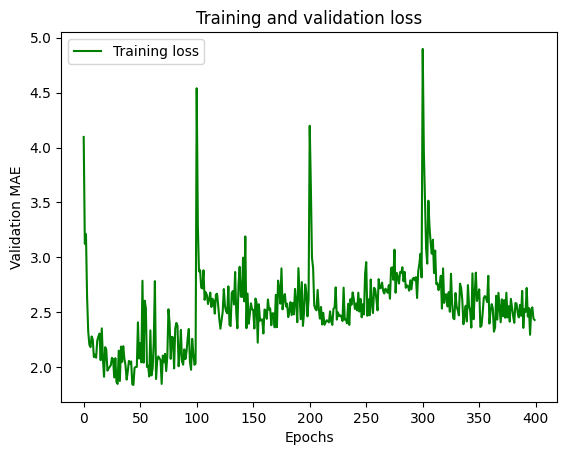

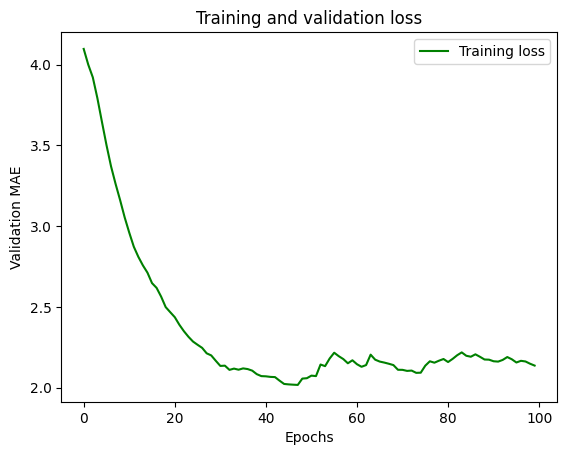

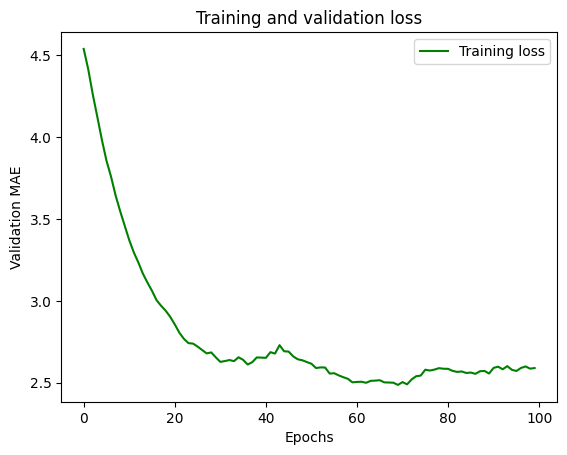

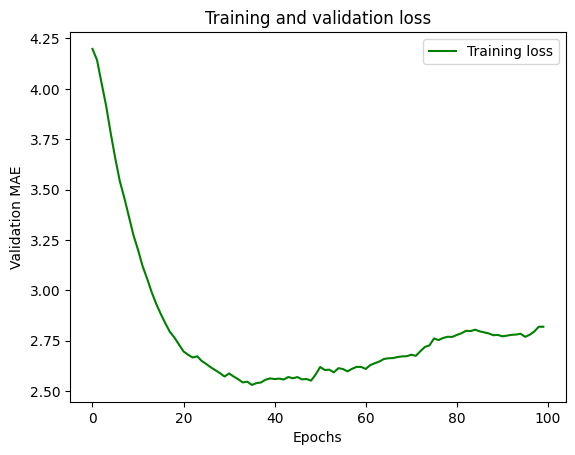

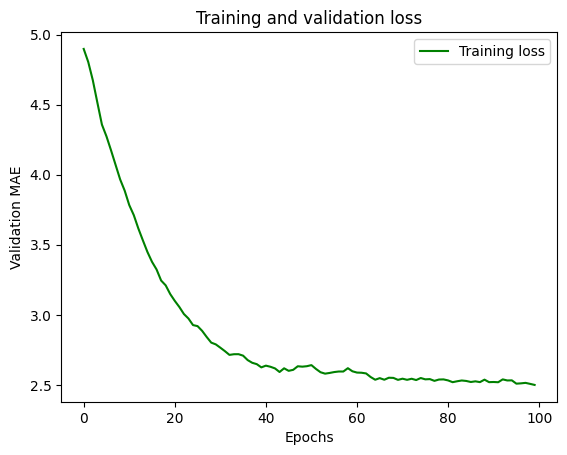

In [8]:
print_performance_metrics({
    'Mean validation MAE scores per model': mean_mae_per_model,
    'Total validation mean MAE for all models': np.mean(mean_mae_per_model)
})


# plot the paramters
plt.plot(all_mae_vals, 'g', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()


smoothed_pts = smooth_curve(all_mae_vals[:100])

# plot the paramters
plt.plot(smoothed_pts, 'g', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

smoothed_pts = smooth_curve(all_mae_vals[100:200])

# plot the paramters
plt.plot(smoothed_pts, 'g', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

smoothed_pts = smooth_curve(all_mae_vals[200:300])

# plot the paramters
plt.plot(smoothed_pts, 'g', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

smoothed_pts = smooth_curve(all_mae_vals[300:400])

# plot the paramters
plt.plot(smoothed_pts, 'g', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.legend()
plt.show()

In [9]:
arr = np.array([1, 2, 3, 4, 5])
arr[2:]

array([3, 4, 5])

In [10]:
arr[:2]

array([1, 2])